In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ----------------------
# 0. Install and Import Packages
# ----------------------
!pip install numpy==1.26.0 --force-reinstall --quiet
!pip install shap --upgrade --quiet
!pip install tensorflow --upgrade --quiet
#!pip install --upgrade --force-reinstall numpy
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Descriptive Statistics:
count    11060.000000
mean        16.634539
std          9.395639
min          2.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         56.000000
Name: rating_count, dtype: float64


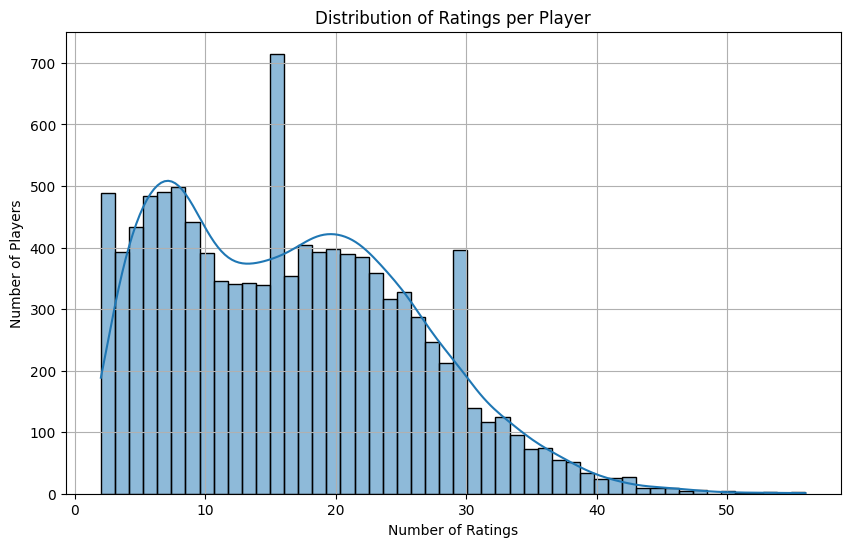

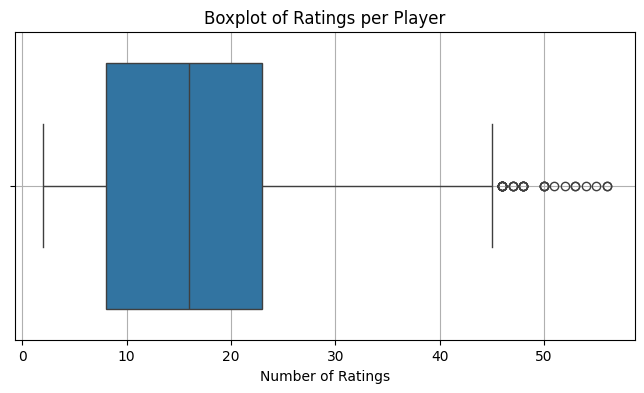

In [3]:
# Load the Database
db_path = '/content/drive/MyDrive/Yoni/soccer/database.sqlite'
conn = sqlite3.connect(db_path)

# Query: Ratings per Player
query = """
SELECT player_api_id, COUNT(*) AS rating_count
FROM Player_Attributes
GROUP BY player_api_id
"""

ratings_per_player_df = pd.read_sql_query(query, conn)
conn.close()

#  Basic Stats
print("\nDescriptive Statistics:")
print(ratings_per_player_df['rating_count'].describe())

# Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_player_df['rating_count'], bins=50, kde=True)
plt.title('Distribution of Ratings per Player')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Players')
plt.grid(True)
plt.show()

#  Boxplot to Visualize Outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=ratings_per_player_df['rating_count'])
plt.title('Boxplot of Ratings per Player')
plt.xlabel('Number of Ratings')
plt.grid(True)
plt.show()


My notes

How Much Time Different Numbers of Ratings Cover (in Years):
8 Ratings:

Median coverage: ~6.58 years

25% of players cover at least ~5 years, 75% cover up to ~8.77 years.

10 Ratings:

Median coverage: ~7.73 years

Up to ~9.35 years for 75% of players.

15 Ratings:

Median coverage: ~8.64 years

Typically covers almost a full decade of data.

Conclusion:
8 ratings typically cover ~6–7 years of a player’s career, which is reasonable for modeling early to mid-career development.



Age Statistics:
count    180901.000000
mean         25.877872
std           4.472182
min          16.002738
25%          22.422998
50%          25.596167
75%          28.988364
max          39.991786
Name: age, dtype: float64


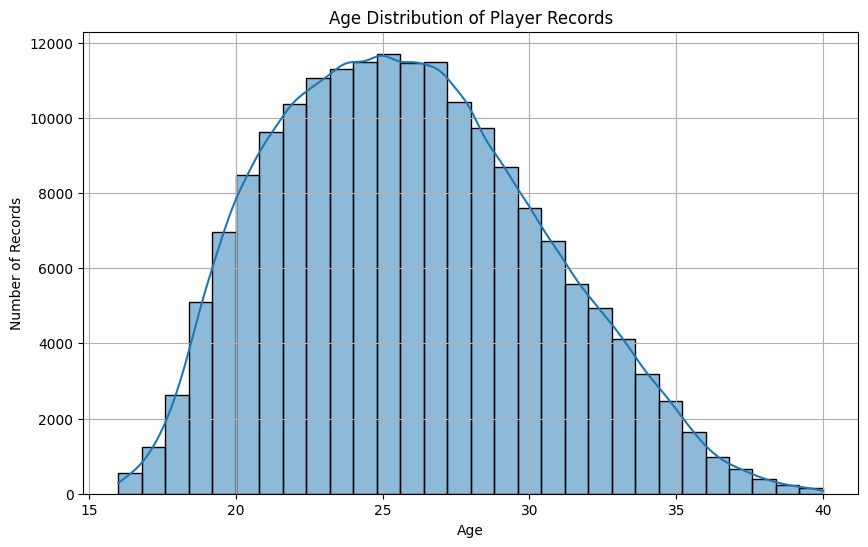

In [4]:
# Load Player_Attributes (dynamic data)
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
player_attr_query = """
SELECT player_api_id, date
FROM Player_Attributes
"""
player_attr_df = pd.read_sql_query(player_attr_query, conn)

# Load Player (static data for birthdays)
player_query = """
SELECT player_api_id, birthday
FROM Player
"""
player_df = pd.read_sql_query(player_query, conn)
conn.close()

# Process Dates
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])
player_df['birthday'] = pd.to_datetime(player_df['birthday'])

# Merge and Compute Age
data = player_attr_df.merge(player_df, on='player_api_id', how='left')
data['age'] = (data['date'] - data['birthday']).dt.days / 365.25

# Filter Out Unrealistic Ages (Optional)
data = data[(data['age'] >= 16) & (data['age'] <= 40)]

# Show Summary Statistics
print("\nAge Statistics:")
print(data['age'].describe())

# Plot Histogram (Optional)


plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=30, kde=True)
plt.title('Age Distribution of Player Records')
plt.xlabel('Age')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.preprocessing.sequence import pad_sequences

conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    player_api_id, date, overall_rating, potential, preferred_foot,
    attacking_work_rate, defensive_work_rate, vision, aggression, positioning,
    acceleration, sprint_speed, stamina, strength, dribbling, finishing, short_passing
FROM Player_Attributes
ORDER BY player_api_id, date
"""

player_df = pd.read_sql_query(query, conn)
conn.close()

player_df['date'] = pd.to_datetime(player_df['date'])

baseline_rating = 30
player_df['achievement_ratio'] = (
    np.log1p(player_df['overall_rating'] - baseline_rating) /
    np.log1p(player_df['potential'] - baseline_rating)
).clip(upper=1.0).fillna(0)

for col in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    le = LabelEncoder()
    player_df[col] = le.fit_transform(player_df[col].astype(str))

features = [
    'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning', 'acceleration', 'sprint_speed',
    'stamina', 'strength', 'dribbling', 'finishing', 'short_passing', 'achievement_ratio'
]

scaler = StandardScaler()
player_df[features] = scaler.fit_transform(player_df[features])

sequences = []
player_ids = []
max_sequence_len = 30

for player_id, group in player_df.groupby('player_api_id'):
    seq = group.sort_values('date')[features].values
    sequences.append(seq)
    player_ids.append(player_id)

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, dtype='float32', padding='pre', truncating='pre')

final_ratings = player_df.groupby('player_api_id').last().reset_index()
final_ratings['label'] = (final_ratings['achievement_ratio'] >= 0.9).astype(int)
labels = final_ratings.set_index('player_api_id').loc[player_ids]['label'].values

np.save('/content/drive/MyDrive/Yoni/player_sequences.npy', padded_sequences)
np.save('/content/drive/MyDrive/Yoni/player_labels.npy', labels)


In [6]:
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    p.player_name,
    pa.date,
    pa.overall_rating,
    pa.potential
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE p.player_api_id IN (
    SELECT player_api_id
    FROM Player_Attributes
    GROUP BY player_api_id
    HAVING COUNT(DISTINCT potential) > 1
)
ORDER BY p.player_name, pa.date
LIMIT 100;
"""

changing_potential_df = pd.read_sql_query(query, conn)
conn.close()

changing_potential_df.head(20)  # Display the first 20 records


player_name                 date  overall_rating  potential
0   Aaron Appindangoye  2007-02-22 00:00:00              61         65
1   Aaron Appindangoye  2015-03-20 00:00:00              61         65
2   Aaron Appindangoye  2015-09-21 00:00:00              62         66
3   Aaron Appindangoye  2015-11-19 00:00:00              67         71
4   Aaron Appindangoye  2016-02-18 00:00:00              67         71
5      Aaron Cresswell  2007-02-22 00:00:00              53         60
6      Aaron Cresswell  2008-08-30 00:00:00              53         60
7      Aaron Cresswell  2009-02-22 00:00:00              47         60
8      Aaron Cresswell  2009-08-30 00:00:00              52         65
9      Aaron Cresswell  2010-02-22 00:00:00              51         64
10     Aaron Cresswell  2010-08-30 00:00:00              54         65
11     Aaron Cresswell  2011-08-30 00:00:00              64         68
12     Aaron Cresswell  2012-02-22 00:00:00              65         68
13     Aaron Cresswell  2012-08-31 00:00:00              68         80
14     Aaron Cresswell  2013-02-15 00:00:00              69         80
15     Aaron Cresswell  2013-02-22 00:00:00              69         80
16     Aaron Cresswell  2013-03-15 00:00:00              69         80
17     Aaron Cresswell  2013-03-22 00:00:00              69         80
18     Aaron Cresswell  2013-05-03 00:00:00              69         80
19     Aaron Cresswell  2013-09-20 00:00:00              69         79

FEATURE EXTRACTION

In [13]:
from scipy.stats import mode

# Load Data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')  # Update this path as needed

player_attr_query = """
SELECT player_api_id, date, overall_rating, potential, preferred_foot,
       attacking_work_rate, defensive_work_rate, vision, aggression, positioning,
       acceleration, sprint_speed, stamina, strength, dribbling, finishing, short_passing
FROM Player_Attributes
ORDER BY player_api_id, date
"""

player_query = """
SELECT player_api_id, birthday, height, weight
FROM Player
"""

player_attr_df = pd.read_sql_query(player_attr_query, conn)
player_df = pd.read_sql_query(player_query, conn)
conn.close()

# Preprocess Dates and Merge
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])
player_df['birthday'] = pd.to_datetime(player_df['birthday'])
data = player_attr_df.merge(player_df, on='player_api_id', how='left')
data['age'] = (data['date'] - data['birthday']).dt.days / 365.25
data = data[(data['age'] >= 16) & (data['age'] <= 40)]

# Categorical Encoding Function
def encode_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Feature Extraction Function
def compute_full_features(group):
    group = group.sort_values('age')
    ratings = group['overall_rating'].values
    ages = group['age'].values
    potential = group['potential'].values[-1]

    first_rating, final_rating = ratings[0], ratings[-1]
    first_age, final_age = ages[0], ages[-1]
    rating_at_21 = ratings[ages <= 21][-1] if any(ages <= 21) else first_rating

    early_growth = rating_at_21 - first_rating
    late_growth = final_rating - rating_at_21
    total_growth = final_rating - first_rating
    years_covered = final_age - first_age if final_age > first_age else 1
    growth_rate = total_growth / years_covered
    max_growth = np.max(np.diff(ratings)) if len(ratings) > 1 else 0
    volatility = np.std(np.diff(ratings)) if len(ratings) > 1 else 0
    peak_age = ages[np.argmax(ratings)]
    years_to_peak = peak_age - first_age
    early_achievement = rating_at_21 / potential if potential > 0 else 0
    final_achievement = final_rating / potential if potential > 0 else 0

    # Dynamic Feature Aggregations
    dynamic_feats = {}
    dynamic_attributes = ['vision', 'aggression', 'positioning', 'acceleration', 'sprint_speed',
                          'stamina', 'strength', 'dribbling', 'finishing', 'short_passing']
    for feat in dynamic_attributes:
        dynamic_feats[f'{feat}_mean'] = group[feat].mean()
        dynamic_feats[f'{feat}_max'] = group[feat].max()
        dynamic_feats[f'{feat}_final'] = group[feat].iloc[-1]
        dynamic_feats[f'{feat}_early_mean'] = group[group['age'] <= 21][feat].mean() if any(group['age'] <= 21) else np.nan

    # Categorical Features
    preferred_foot = encode_mode(group['preferred_foot'])
    attacking_work_rate = encode_mode(group['attacking_work_rate'])
    defensive_work_rate = encode_mode(group['defensive_work_rate'])

    # Static Features
    height = group['height'].iloc[-1]
    weight = group['weight'].iloc[-1]

    return pd.Series({
        'early_growth': early_growth,
        'late_growth': late_growth,
        'total_growth': total_growth,
        'growth_rate': growth_rate,
        'max_1yr_growth': max_growth,
        'growth_volatility': volatility,
        'years_to_peak': years_to_peak,
        'early_achievement_ratio': early_achievement,
        'final_achievement_ratio': final_achievement,
        'final_rating': final_rating,
        'potential': potential,
        'preferred_foot': preferred_foot,
        'attacking_work_rate': attacking_work_rate,
        'defensive_work_rate': defensive_work_rate,
        'height': height,
        'weight': weight,
        **dynamic_feats
    })

# Apply Feature Extraction
features_df = data.groupby('player_api_id', group_keys=False).apply(
    compute_full_features, include_groups=False
).reset_index()

# Save Extracted Features
features_df.to_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv', index=False)




###  **Feature Explanations**

| Feature Name                  | What It Captures                        | How It’s Computed                                                                                                 |
| ----------------------------- | --------------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **early\_growth**             | Early career development.               | `rating_at_21 - first_rating`<br>Find the rating at or before age 21 and subtract the first recorded rating.      |
| **late\_growth**              | Development after age 21.               | `final_rating - rating_at_21`<br>Final recorded rating minus the rating at age 21.                                |
| **total\_growth**             | Overall improvement.                    | `final_rating - first_rating`<br>How much the player improved over their entire observed career.                  |
| **growth\_rate**              | Consistency of growth per year.         | `total_growth / (final_age - first_age)`<br>Averages how many rating points were gained each year.                |
| **max\_1yr\_growth**          | Explosiveness of improvement.           | `max(diff(ratings))`<br>Biggest single-year rating jump; measures breakout seasons.                               |
| **growth\_volatility**        | Stability of development.               | `std(diff(ratings))`<br>How variable year-to-year rating changes are; high values mean inconsistent growth.       |
| **years\_to\_peak**           | How fast the player peaked.             | `age_at_peak - first_age`<br>Time taken to reach the highest recorded rating.                                     |
| **early\_achievement\_ratio** | How close they were to potential early. | `rating_at_21 / potential`<br>Proportion of potential achieved by age 21; higher values indicate early achievers. |
| **final\_achievement\_ratio** | How close they came to their potential. | `final_rating / potential`<br>Final career achievement ratio, directly related to your target variable.           |
| **final\_rating**             | Final recorded rating.                  | Extracted directly from the last known record.                                                                    |
| **potential**                 | Final recorded potential.               | Extracted directly from the last known record.                                                                    |

---

###  **Why Some Features Are Not Directly Extractable and Require Processing:**

* **Rating at Age 21 (`rating_at_21`)**:

  * The database does not store player ratings by exact ages.
  * We find the last recorded rating **at or before age 21** from the available data points.

* **Volatility and Max 1-Year Growth**:

  * These require calculating **differences between consecutive ratings** over time, which isn’t directly stored.
  * We compute them using `np.diff(ratings)` over each player's timeline.

* **Years to Peak**:

  * The database doesn’t say when a player peaked.
  * We find the age corresponding to the **maximum rating in the timeline** and subtract the starting age.

* **Achievement Ratios**:

  * The achievement ratio isn’t a raw field.
  * It’s a normalized value:

    * Early: `rating_at_21 / potential`
    * Final: `final_rating / potential`




Basic Feature Statistics:
       player_api_id  early_growth   late_growth  total_growth   growth_rate  \
count   11059.000000  11006.000000  11004.000000  11055.000000  11055.000000   
mean   156593.021069      2.025350      2.860596      4.898417      1.105710   
std    160717.105376      4.615069      7.007793      8.355493      2.753916   
min      2625.000000    -19.000000    -25.000000    -25.000000    -30.437500   
25%     35555.000000      0.000000     -1.000000      0.000000      0.000000   
50%     96620.000000      0.000000      2.000000      4.000000      0.660488   
75%    212471.000000      1.000000      7.000000     10.000000      1.739286   
max    750584.000000     34.000000     36.000000     42.000000     81.994898   

       max_1yr_growth  growth_volatility  years_to_peak  \
count    10303.000000       10303.000000   11059.000000   
mean         4.442978           1.585848       3.385385   
std          3.804919           1.025776       3.065313   
min         -4.0

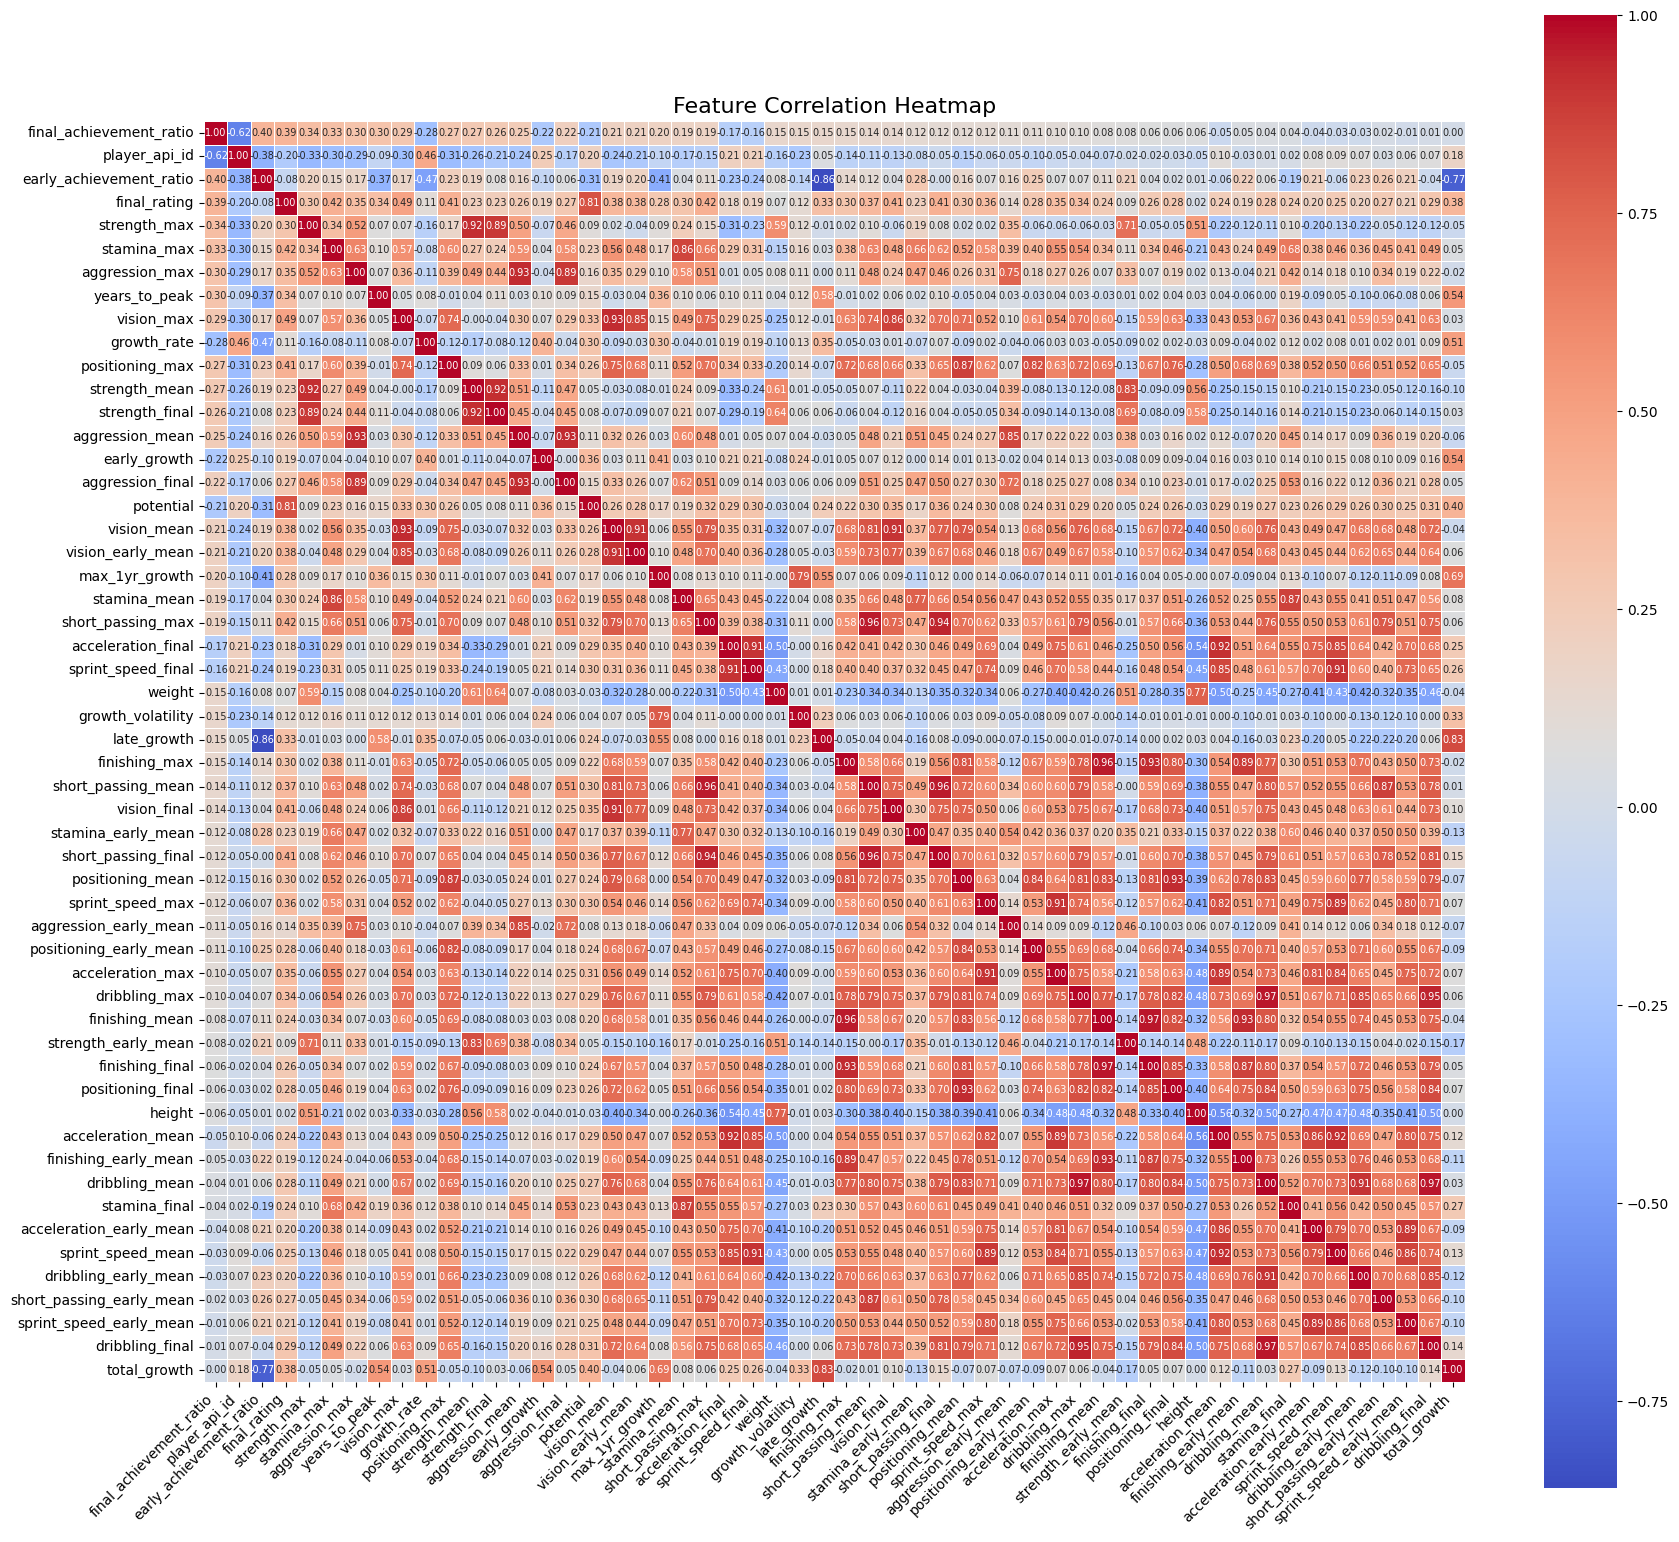

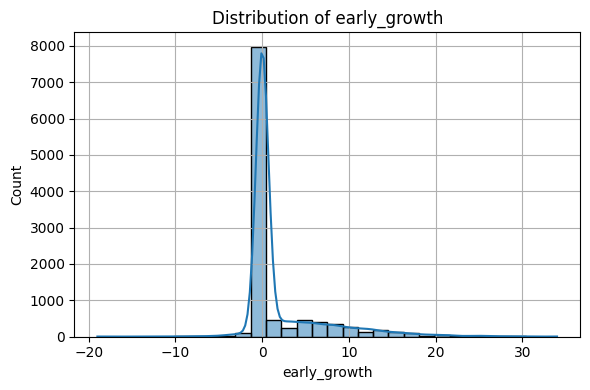

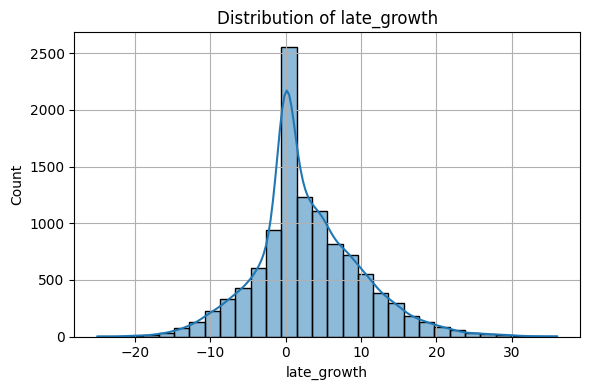

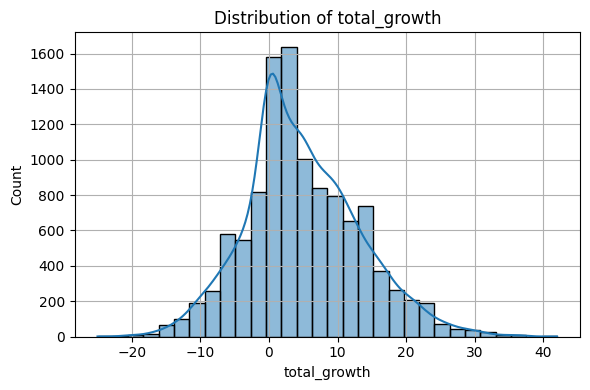

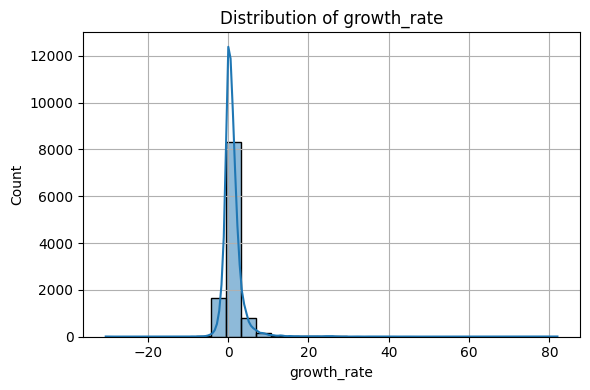

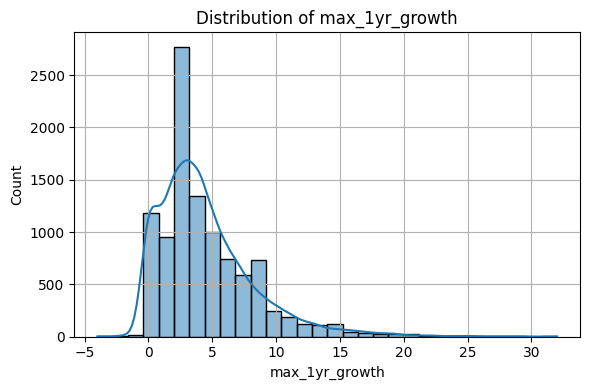

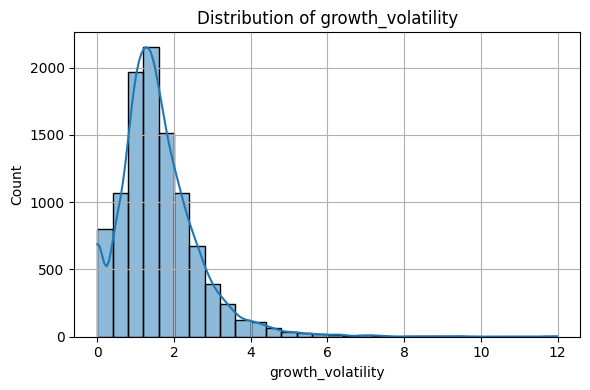

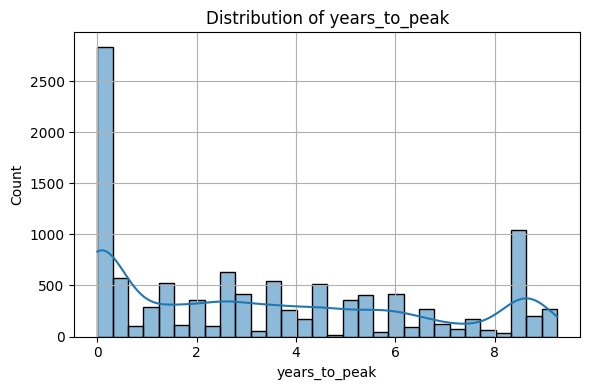

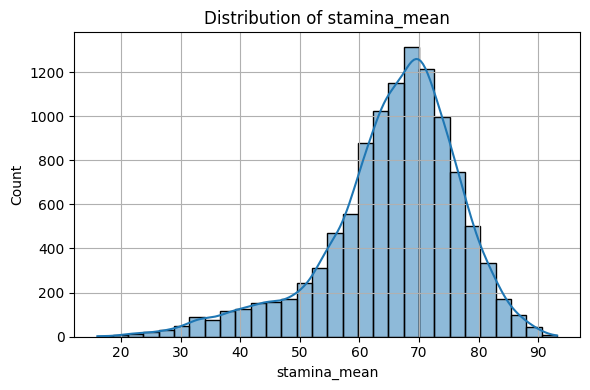

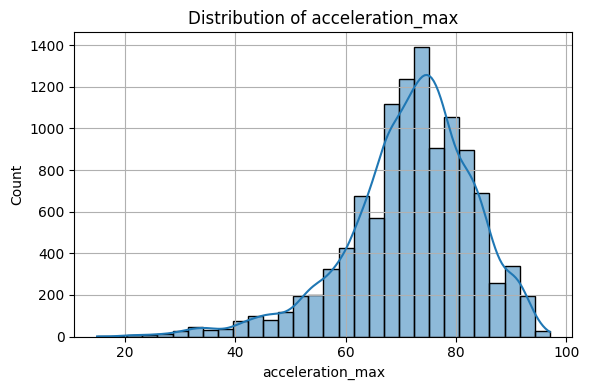

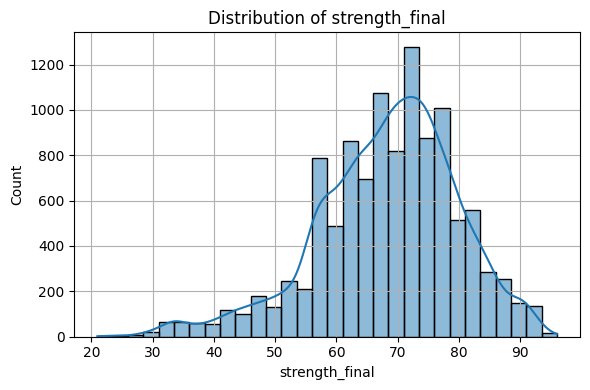

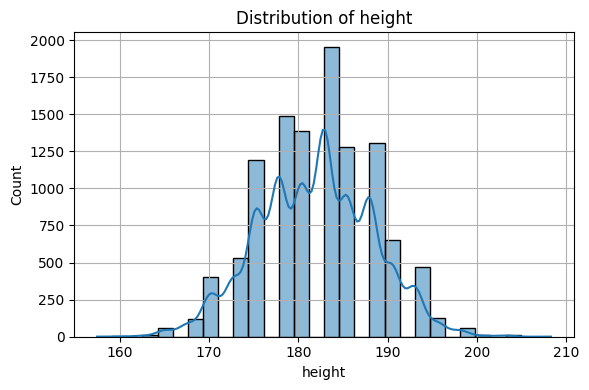

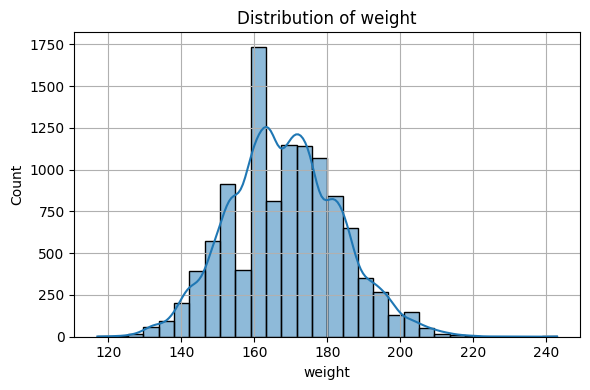

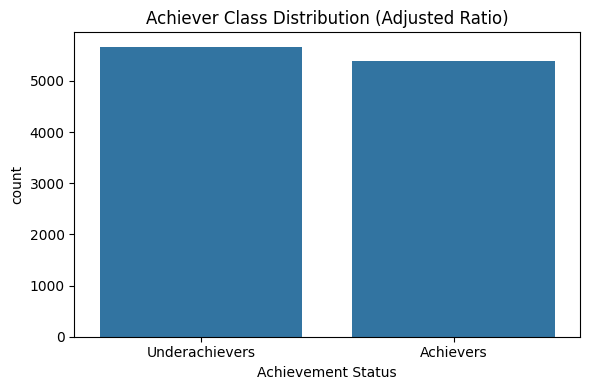

In [18]:
# Load updated extracted features
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')

# 1. Basic Statistics for Numeric Features Only
numeric_features = features_df.select_dtypes(include=[np.number]).columns.tolist()
print("\nBasic Feature Statistics:")
print(features_df[numeric_features].describe())

# 2. Correlation Heatmap (Only for Numeric Features)


plt.figure(figsize=(18, 16))
corr_matrix = features_df[numeric_features].corr()
sorted_features = corr_matrix['final_achievement_ratio'].abs().sort_values(ascending=False).index

sns.heatmap(
    corr_matrix.loc[sorted_features, sorted_features],
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    annot_kws={"size": 7},
    linewidths=0.5,
    square=True
)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Histograms of Key Features (Add New Dynamic Features Here)
key_features = ['early_growth', 'late_growth', 'total_growth', 'growth_rate',
                 'max_1yr_growth', 'growth_volatility', 'years_to_peak',
                 'stamina_mean', 'acceleration_max', 'strength_final', 'height', 'weight']

for feature in key_features:
    if feature in features_df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(features_df[feature].dropna(), bins=30, kde=True)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 4. Compute Adjusted Achievement Ratio Using Logarithmic Scaling
features_df['adjusted_achievement_ratio'] = (
    np.log(features_df['final_rating'] + 1) - np.log(features_df['final_rating'] - features_df['total_growth'] + 1)
) / (
    np.log(features_df['potential'] + 1) - np.log(features_df['final_rating'] - features_df['total_growth'] + 1)
)

features_df['adjusted_achievement_ratio'] = features_df['adjusted_achievement_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(0, 1)

# Define Achievers Using Adjusted Ratio
adjusted_threshold = 0.9  # You can experiment with this threshold
features_df['achiever'] = (features_df['adjusted_achievement_ratio'] >= adjusted_threshold).astype(int)

# Visualize New Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='achiever', data=features_df)
plt.xticks([0, 1], ['Underachievers', 'Achievers'])
plt.title('Achiever Class Distribution (Adjusted Ratio)')
plt.xlabel('Achievement Status')
plt.tight_layout()
plt.show()




Top 10 Players with the Most Ratings:
   player_name  num_ratings    first_rating_date     last_rating_date
0       Danilo          108  2007-02-22 00:00:00  2016-04-07 00:00:00
1         Alex          104  2007-02-22 00:00:00  2016-04-14 00:00:00
2      Douglas           93  2007-02-22 00:00:00  2016-04-21 00:00:00
3       Felipe           89  2007-02-22 00:00:00  2016-05-05 00:00:00
4      Ricardo           84  2007-02-22 00:00:00  2016-01-28 00:00:00
5        Josue           77  2007-02-22 00:00:00  2016-05-12 00:00:00
6      Rafinha           75  2007-02-22 00:00:00  2016-04-21 00:00:00
7     Fernando           75  2007-02-22 00:00:00  2016-05-05 00:00:00
8       Maicon           73  2007-02-22 00:00:00  2016-04-21 00:00:00
9  Scott Brown           71  2007-02-22 00:00:00  2016-04-28 00:00:00


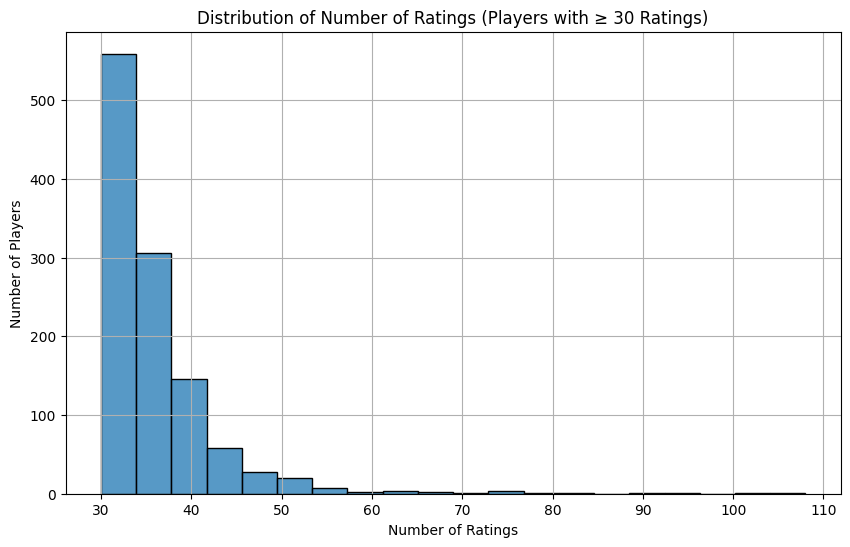

In [25]:
# Connect to the database
conn =sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
# Query: Retrieve player name, number of ratings, first and last rating dates
query = """
SELECT
    p.player_name,
    COUNT(pa.id) AS num_ratings,
    MIN(pa.date) AS first_rating_date,
    MAX(pa.date) AS last_rating_date
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
GROUP BY p.player_name
HAVING num_ratings >= 30
ORDER BY num_ratings DESC;
"""

player_summary_df = pd.read_sql_query(query, conn)
conn.close()

# Display Top 10 Players with the Most Ratings
print("\nTop 10 Players with the Most Ratings:")
print(player_summary_df.head(10))

# Plot Distribution of Players with 30+ Ratings
plt.figure(figsize=(10, 6))
sns.histplot(player_summary_df['num_ratings'], bins=20, kde=False)
plt.title('Distribution of Number of Ratings (Players with ≥ 30 Ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Players')
plt.grid(True)
plt.show()


In [27]:
# Connect to the database
conn =sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
player_name = "Cristiano Ronaldo"  # Change this to any player name you're interested in

query = f"""
SELECT
    p.player_name,
    pa.date,
    pa.overall_rating,
    pa.potential
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE p.player_name = '{player_name}'
ORDER BY pa.date;
"""

player_ratings_df = pd.read_sql_query(query, conn)

print(player_ratings_df)


          player_name                 date  overall_rating  potential
0   Cristiano Ronaldo  2007-02-22 00:00:00              87         92
1   Cristiano Ronaldo  2007-08-30 00:00:00              91         94
2   Cristiano Ronaldo  2008-08-30 00:00:00              91         94
3   Cristiano Ronaldo  2009-02-22 00:00:00              90         94
4   Cristiano Ronaldo  2009-08-30 00:00:00              89         94
5   Cristiano Ronaldo  2010-02-22 00:00:00              89         93
6   Cristiano Ronaldo  2010-08-30 00:00:00              89         94
7   Cristiano Ronaldo  2011-02-22 00:00:00              89         93
8   Cristiano Ronaldo  2011-08-30 00:00:00              92         94
9   Cristiano Ronaldo  2012-02-22 00:00:00              92         94
10  Cristiano Ronaldo  2012-08-31 00:00:00              92         94
11  Cristiano Ronaldo  2013-02-15 00:00:00              92         94
12  Cristiano Ronaldo  2013-03-01 00:00:00              92         94
13  Cristiano Ronald

In [ ]:
player_ranking_df = pd.read_sql_query("""
    SELECT player_name, COUNT(*) as num_ratings
    FROM Player_Attributes pa
    JOIN Player p ON pa.player_api_id = p.player_api_id
    GROUP BY player_name
    ORDER BY num_ratings DESC
    LIMIT 20;
""", conn)

print(player_ranking_df)


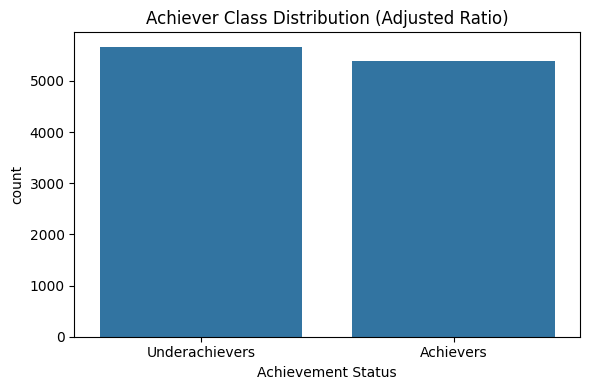

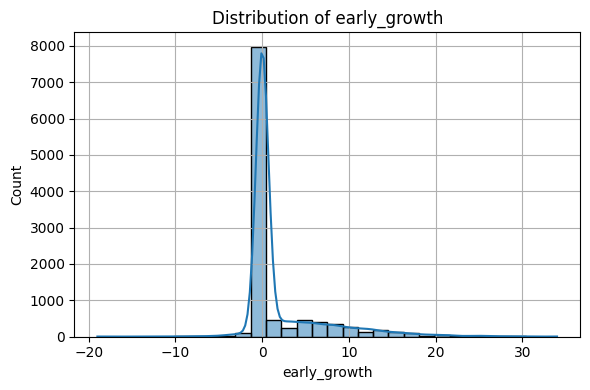

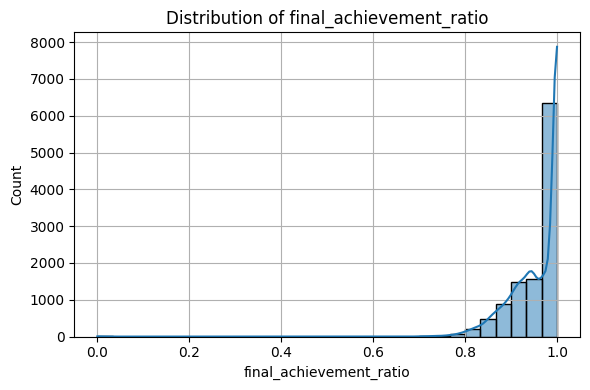

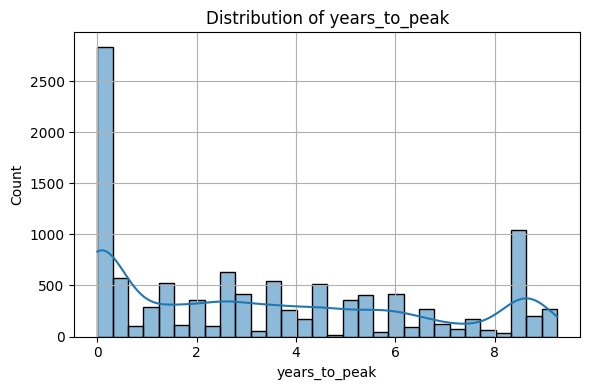

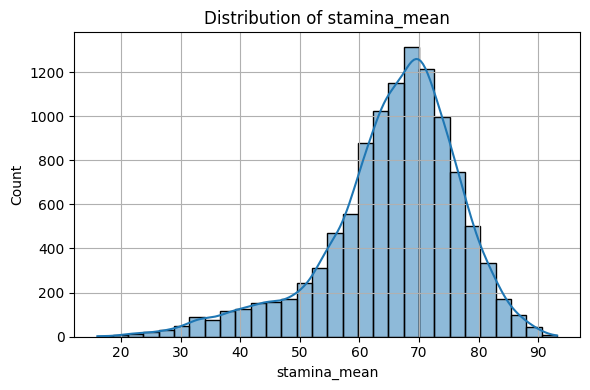

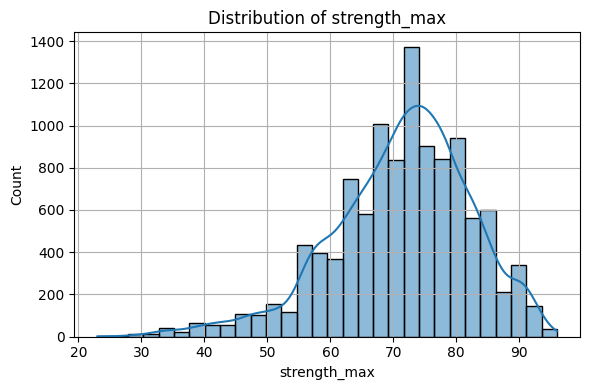

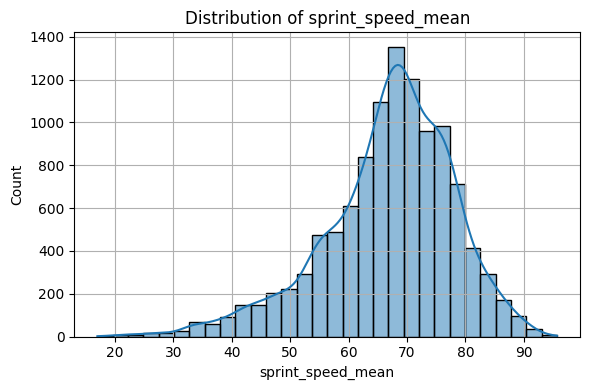

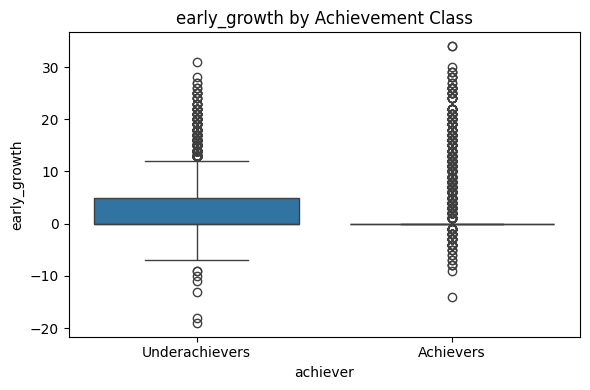

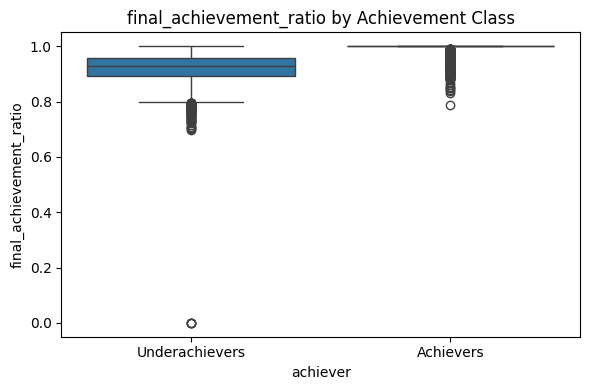

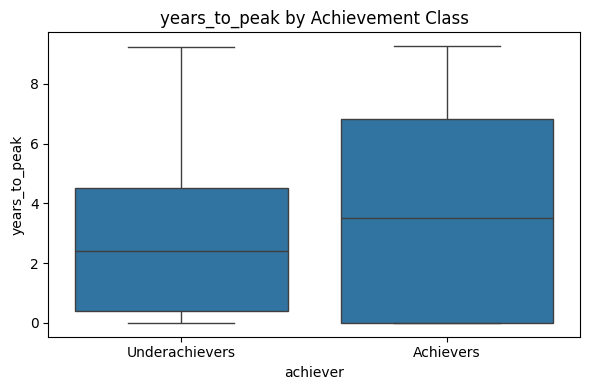

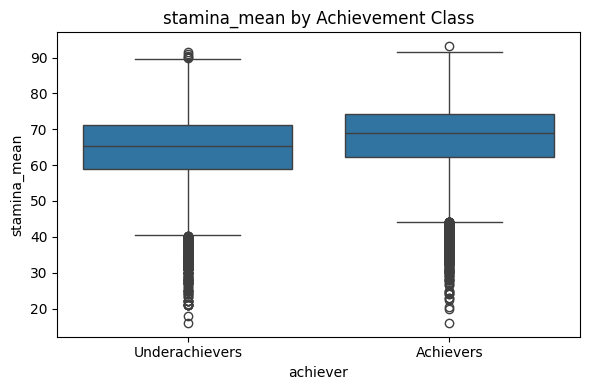

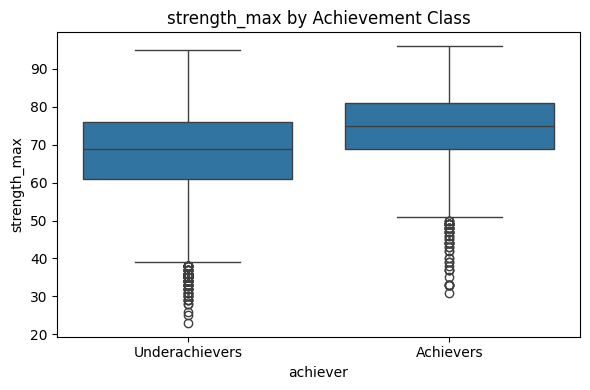

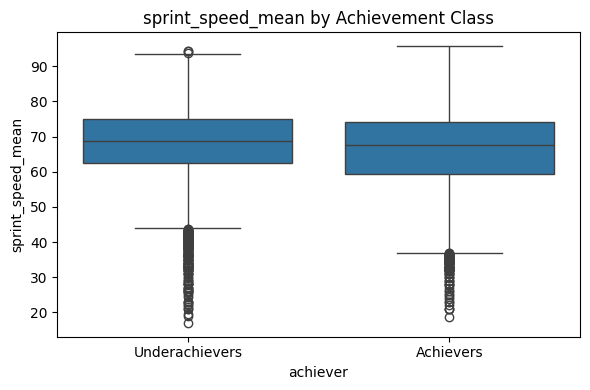

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')

# Calculate Adjusted Achievement Ratio
features_df['adjusted_achievement_ratio'] = (
    np.log(features_df['final_rating'] + 1) - np.log(features_df['final_rating'] - features_df['total_growth'] + 1)
) / (
    np.log(features_df['potential'] + 1) - np.log(features_df['final_rating'] - features_df['total_growth'] + 1)
)

features_df['adjusted_achievement_ratio'] = features_df['adjusted_achievement_ratio'].replace(
    [np.inf, -np.inf], np.nan).fillna(0).clip(0, 1)

# Define Achievement Classes
features_df['achiever'] = (features_df['adjusted_achievement_ratio'] >= 0.9).astype(int)

# --------- Class Distribution Plot ---------
plt.figure(figsize=(6, 4))
sns.countplot(x='achiever', data=features_df)
plt.xticks([0, 1], ['Underachievers', 'Achievers'])
plt.title('Achiever Class Distribution (Adjusted Ratio)')
plt.xlabel('Achievement Status')
plt.tight_layout()
plt.savefig('class_balance.png')
plt.show()

# --------- Histograms for Key Features ---------
key_features = ['early_growth', 'final_achievement_ratio', 'years_to_peak', 'stamina_mean', 'strength_max', 'sprint_speed_mean']

for feature in key_features:
    if feature in features_df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(features_df[feature].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{feature}_distribution.png')
        plt.show()

# --------- Boxplots Comparing Achievers vs. Underachievers ---------
for feature in key_features:
    if feature in features_df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='achiever', y=feature, data=features_df)
        plt.xticks([0, 1], ['Underachievers', 'Achievers'])
        plt.title(f'{feature} by Achievement Class')
        plt.tight_layout()
        plt.savefig(f'{feature}_boxplot.png')
        plt.show()

# --------- Average Rating Progression by Age ---------
if 'age' in features_df.columns and 'final_rating' in features_df.columns:
    age_rating_df = features_df.groupby('age')['final_rating'].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=age_rating_df, x='age', y='final_rating')
    plt.title('Average Final Rating by Age')
    plt.xlabel('Age')
    plt.ylabel('Average Final Rating')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('average_rating_by_age.png')
    plt.show()


TAKING INTO ACCOUNT TEMPORAL DATA:

In [37]:

# Load from the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT player_api_id, date, overall_rating, potential
FROM Player_Attributes
"""

player_attr_df = pd.read_sql_query(query, conn)
conn.close()

# Save it for reuse
player_attr_df.to_csv('/content/drive/MyDrive/Yoni/soccer/player_attributes_full.csv', index=False)


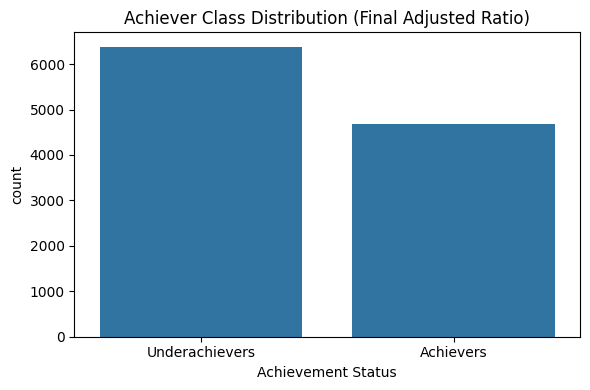

In [40]:
# Load the data
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')
player_attr_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_attributes_full.csv')

# Preprocess Dates
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])



BASELINE = 30

player_attr_df['adjusted_achievement_ratio'] = (
    np.log1p(player_attr_df['overall_rating'] - BASELINE) /
    np.log1p(player_attr_df['potential'] - BASELINE)
).clip(0, 1).fillna(0)



agg_df = player_attr_df.groupby('player_api_id').agg({
    'adjusted_achievement_ratio': ['mean', 'max', 'last'],
    'overall_rating': 'last',
    'potential': 'last'
}).reset_index()

agg_df.columns = ['player_api_id', 'mean_adj_ratio', 'max_adj_ratio', 'final_adj_ratio', 'final_rating', 'potential']

# Classify Achievers/Underachievers based on final adjusted ratio
THRESHOLD = 0.95
agg_df['achiever'] = (agg_df['final_adj_ratio'] >= THRESHOLD).astype(int)


plt.figure(figsize=(6, 4))
sns.countplot(x='achiever', data=agg_df)
plt.xticks([0, 1], ['Underachievers', 'Achievers'])
plt.title('Achiever Class Distribution (Final Adjusted Ratio)')
plt.xlabel('Achievement Status')
plt.tight_layout()
plt.show()


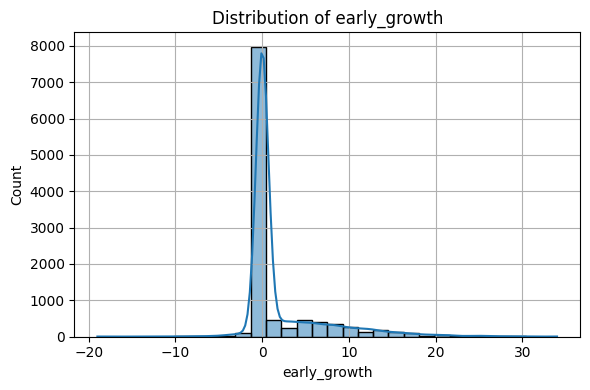

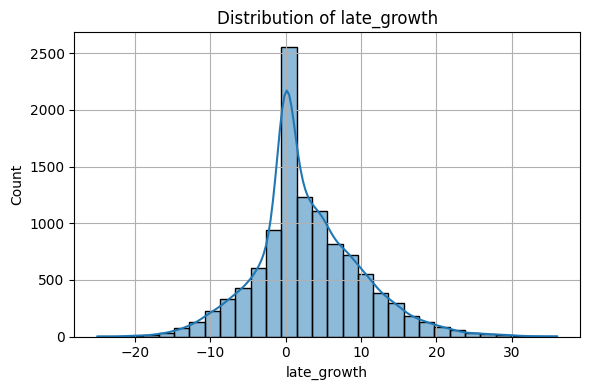

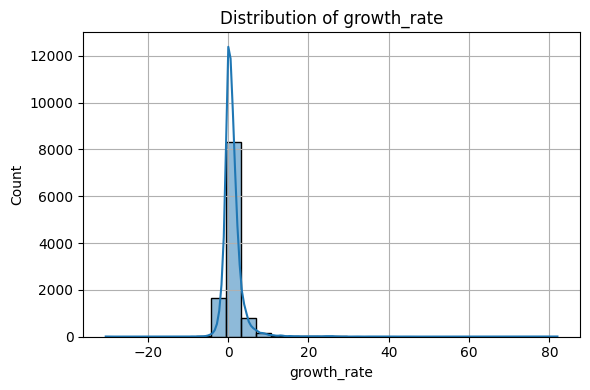

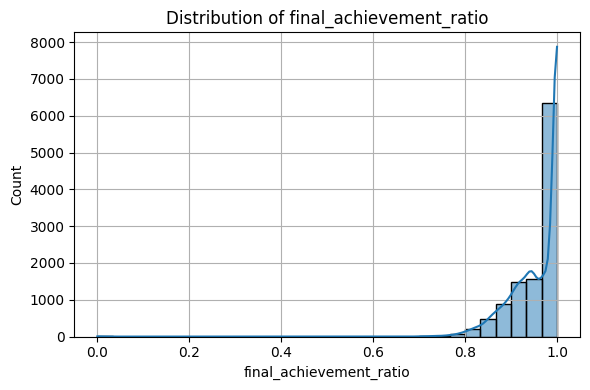

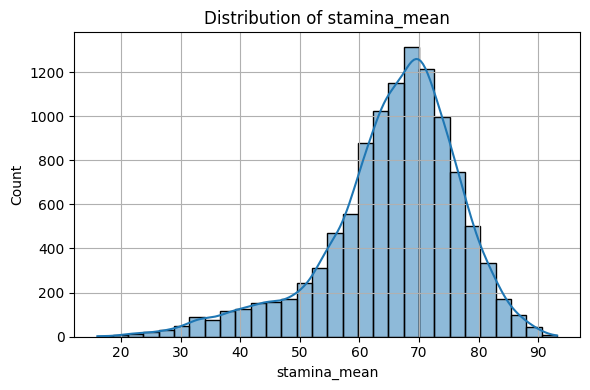

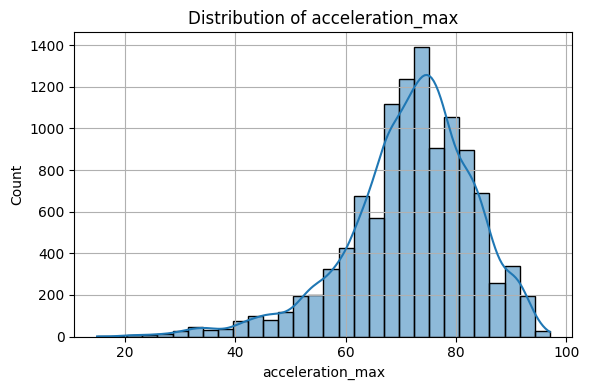

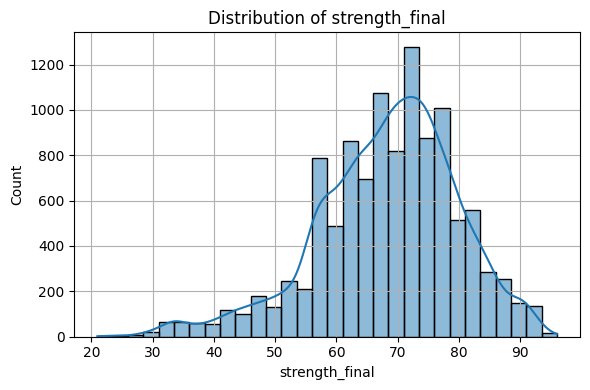

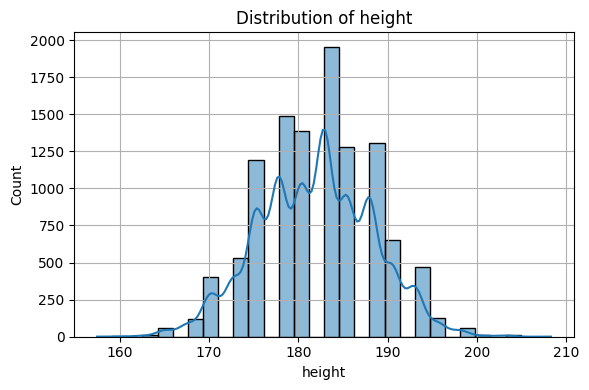

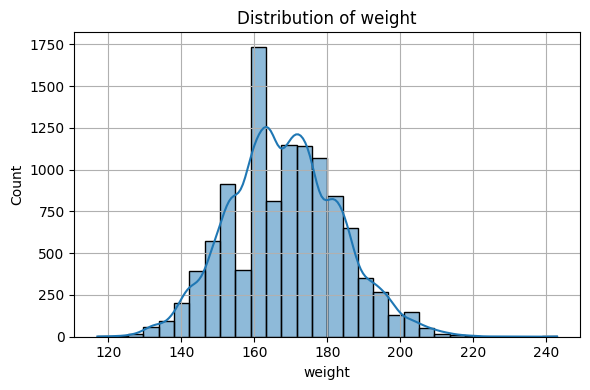

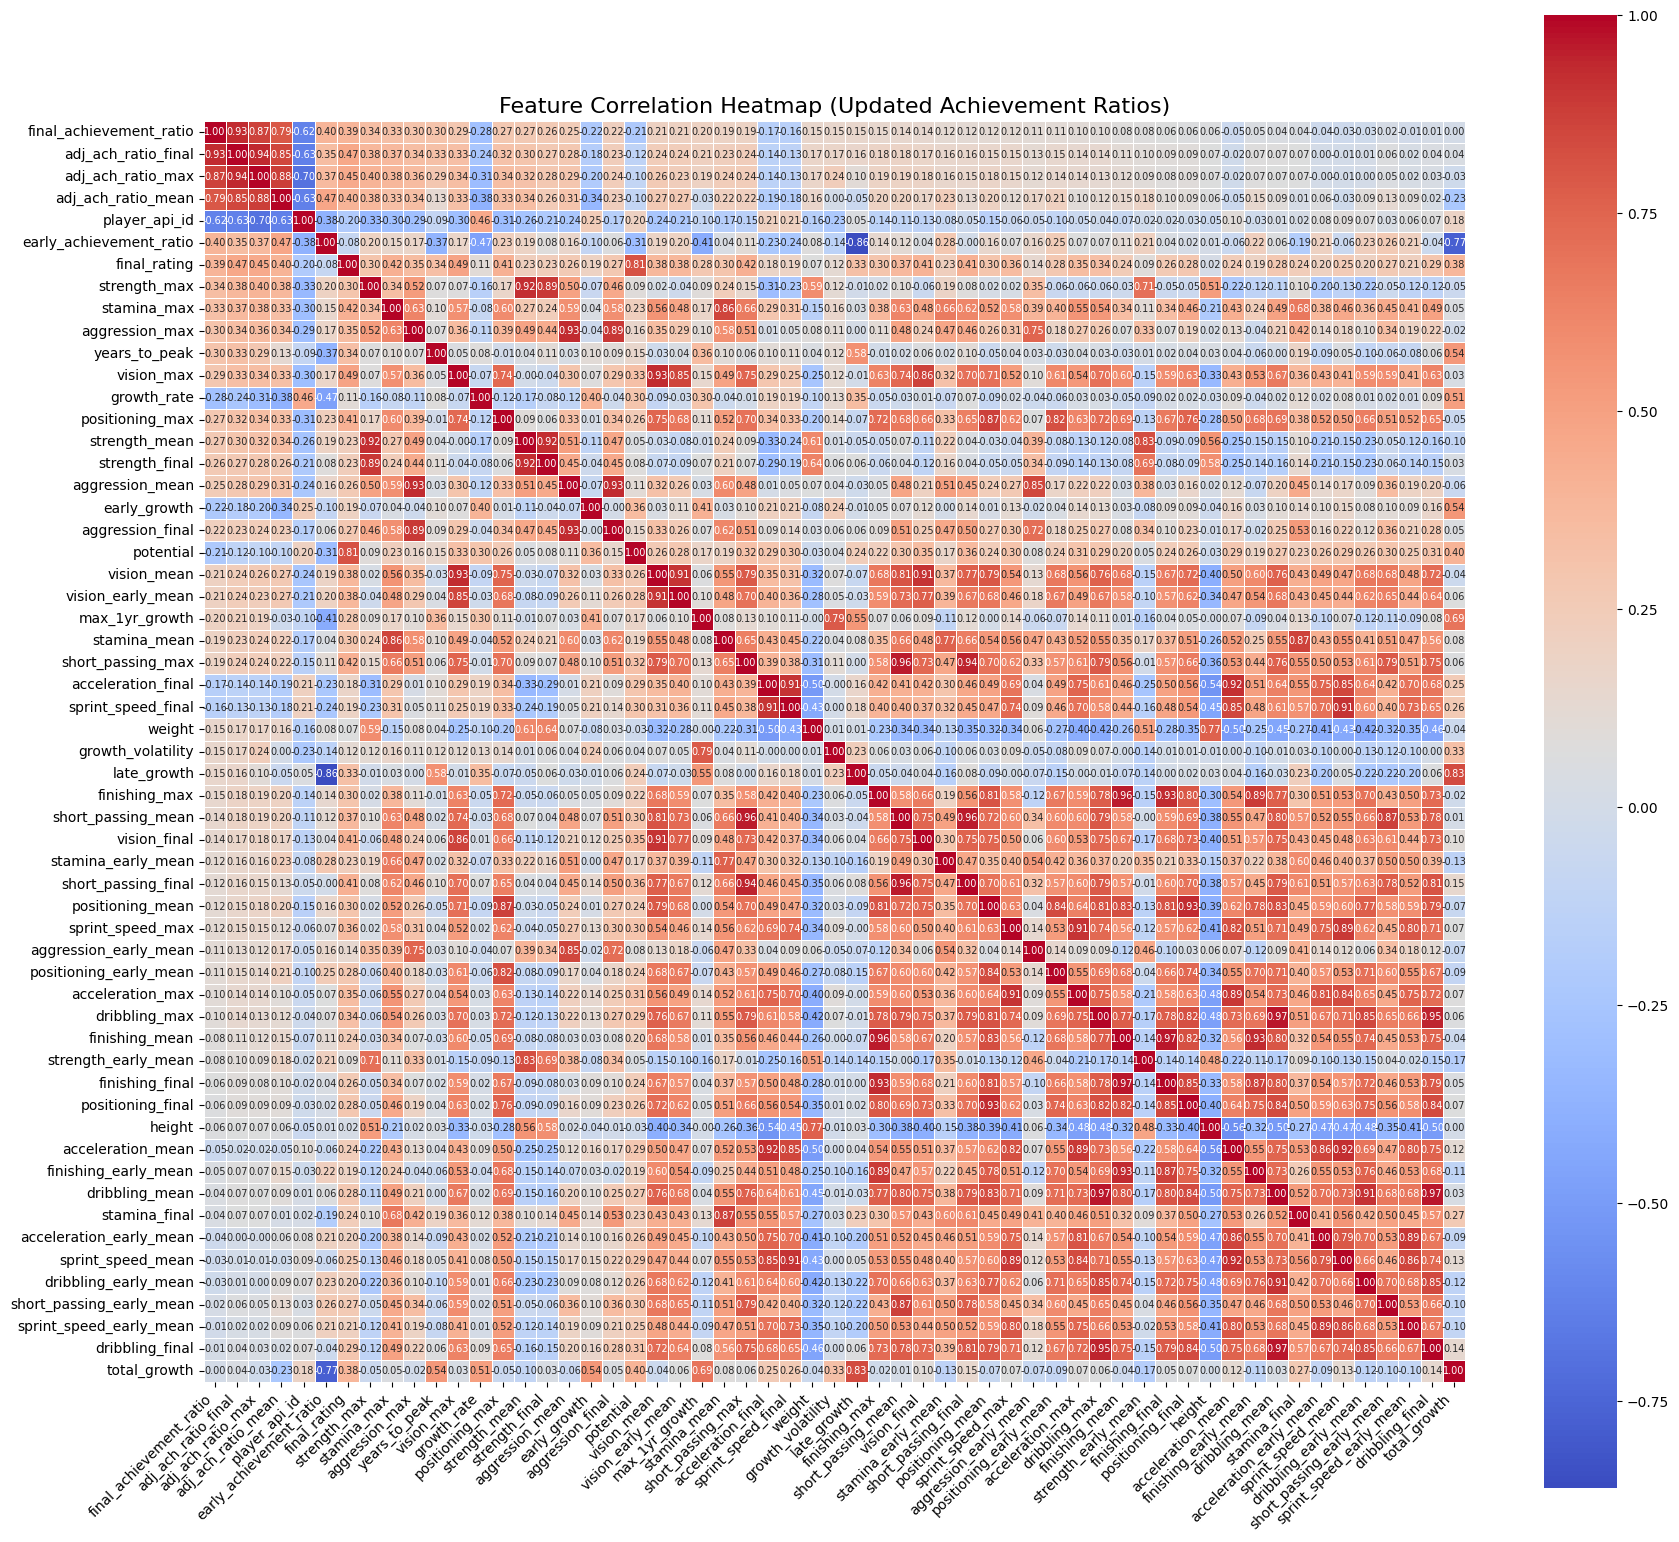

In [36]:
numeric_features = features_df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(18, 16))
corr_matrix = features_df[numeric_features].corr()
sorted_features = corr_matrix['final_achievement_ratio'].abs().sort_values(ascending=False).index

sns.heatmap(
    corr_matrix.loc[sorted_features, sorted_features],
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    annot_kws={"size": 7},
    linewidths=0.5,
    square=True
)

plt.title('Feature Correlation Heatmap (Updated Achievement Ratios)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd

# Load the full player attributes dataset
player_attr_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_attributes_full.csv')

# Calculate the number of ratings per player
ratings_per_player = player_attr_df.groupby('player_api_id').size()

# Filter players with at least 8 ratings
filtered_players = ratings_per_player[ratings_per_player >= 8].index

# Final number of unique players retained
final_player_count = len(filtered_players)
print(f"Final number of players after filtering: {final_player_count}")


Final number of players after filtering: 8770


In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Data
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')

# Define target with stricter threshold: Achievers > 95%
target = (features_df['final_achievement_ratio'] > 0.95).astype(int)

# Drop leakage and non-feature columns
drop_cols = ['player_id', 'final_achievement_ratio', 'potential', 'final_rating','early_achievement_ratio','player_api_id']
X = features_df.drop(columns=drop_cols, errors='ignore')

# Keep only numeric features and handle missing values
X = X.select_dtypes(include=['number']).fillna(0)

# Optional: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42, stratify=target)

# Train XGBoost Classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Beeswarm)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, max_display=20, show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Yoni/soccer/shap_summary_plot_corrected_95.png')
plt.close()

# SHAP Bar Plot (Mean Absolute SHAP Values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", max_display=20, show=False)

# Fix the cutoff by adjusting subplot margins
plt.gcf().subplots_adjust(left=0.3)
plt.xlabel("")  # Remove x-axis label completely if it's redundant

plt.savefig('/content/drive/MyDrive/Yoni/soccer/shap_bar_plot_corrected_95.png', bbox_inches='tight')
plt.close()




print(" SHAP plots regenerated with achievers > 95% threshold. Files saved to Google Drive.")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:05:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 SHAP plots regenerated with achievers > 95% threshold. Files saved to Google Drive.


PREDICTIVE MODELING

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, f1_score, roc_auc_score, confusion_matrix)

# Load Data
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')

# Strictly Drop Leakage Features
drop_cols = ['player_id', 'player_api_id', 'final_achievement_ratio',
              'potential', 'final_rating', 'early_achievement_ratio', 'age']

X = features_df.drop(columns=drop_cols, errors='ignore')
X = X.select_dtypes(include=['number']).fillna(0)

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### ----------- REGRESSION TASK -----------
target_reg = features_df['final_achievement_ratio']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target_reg, test_size=0.2, random_state=42)

# Train Regression Model
reg_model = Ridge()
reg_model.fit(X_train, y_train)
predictions = reg_model.predict(X_test)

# Regression Evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"[Regression] MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

### ----------- CLASSIFICATION TASK -----------
target_clf = (features_df['final_achievement_ratio'] > 0.95).astype(int)

# Train/Test Split (with stratification for class balance)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target_clf, test_size=0.2, random_state=42, stratify=target_clf)

# Train Classifier
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train)
preds = clf_model.predict(X_test)
probs = clf_model.predict_proba(X_test)[:, 1]

# Classification Evaluation
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, probs)
cm = confusion_matrix(y_test, preds)

print(f"[Classification] Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print("[Classification] Confusion Matrix:\n", cm)


[Regression] MSE: 0.0017, MAE: 0.0280, R²: 0.4796
[Classification] Accuracy: 0.8612, F1: 0.8930, ROC AUC: 0.9380
[Classification] Confusion Matrix:
 [[ 624  192]
 [ 115 1281]]


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("\n[Cross-Validation Results]")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, scoring='accuracy')
cv_f1 = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, scoring='f1')
cv_auc = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, scoring='roc_auc')

print(f"CV Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
print(f"CV F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"CV ROC AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")


Realistic Scouting Simulation—predicting long-term success using only information that would have been available before or at age 21.

In [62]:


# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

# Load the necessary tables
player_df = pd.read_sql_query("SELECT player_api_id, birthday FROM Player", conn)
player_attr_df = pd.read_sql_query("SELECT player_api_id, date FROM Player_Attributes", conn)

# Convert date fields to datetime
player_df['birthday'] = pd.to_datetime(player_df['birthday'])
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])

# Merge to compute age at each observation
player_attr_df = player_attr_df.merge(player_df, on='player_api_id', how='left')
player_attr_df['age'] = (player_attr_df['date'] - player_attr_df['birthday']).dt.days // 365

# Filter for records where age is 21 or younger
early_career_df = player_attr_df[player_attr_df['age'] <= 21]

# Count unique players with at least 1 record at or before age 21
early_career_players = early_career_df['player_api_id'].nunique()
print(f"Number of unique players with at least one record at or before age 21: {early_career_players}")


Number of unique players with at least one record at or before age 21: 7154


In [63]:
# Check how many players have at least 3 records before age 21
min_records = 3
player_record_counts = early_career_df.groupby('player_api_id').size()
qualified_players = (player_record_counts >= min_records).sum()
print(f"Number of players with at least {min_records} records at or before age 21: {qualified_players}")


Number of players with at least 3 records at or before age 21: 4683


<Axes: >

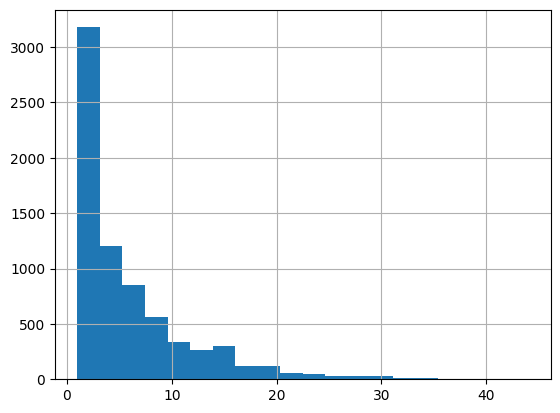

In [64]:
player_record_counts.hist(bins=20)


In [60]:
import sqlite3
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load Data from Database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

player_df = pd.read_sql_query("SELECT player_api_id, birthday FROM Player", conn)
player_attr_df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

# Step 2: Compute Age at Each Observation
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])
player_df['birthday'] = pd.to_datetime(player_df['birthday'])

player_attr_df = player_attr_df.merge(player_df, on='player_api_id', how='left')
player_attr_df['age'] = (player_attr_df['date'] - player_attr_df['birthday']).dt.days // 365

# Filter for early career (age <= 21)
early_career_df = player_attr_df[player_attr_df['age'] <= 21]

print(f"Number of early-career records: {early_career_df.shape[0]}")

# Step 3: Load Final Features and Merge with Early-Career IDs
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')
early_career_player_ids = early_career_df['player_api_id'].unique()
early_features_df = features_df[features_df['player_api_id'].isin(early_career_player_ids)]

# Define target
target_clf = (early_features_df['final_achievement_ratio'] > 0.95).astype(int)

# Step 4: Prepare Datasets
drop_common = ['player_id', 'player_api_id', 'final_achievement_ratio',
                'potential', 'final_rating', 'age']

# Experiment 1A: WITH early_achievement_ratio
drop_with = drop_common.copy()
X_with = early_features_df.drop(columns=drop_with, errors='ignore')
X_with = X_with.select_dtypes(include=['number']).fillna(0)

# Experiment 1B: WITHOUT early_achievement_ratio
drop_without = drop_common + ['early_achievement_ratio']
X_without = early_features_df.drop(columns=drop_without, errors='ignore')
X_without = X_without.select_dtypes(include=['number']).fillna(0)

# Standardize
scaler = StandardScaler()
X_with_scaled = scaler.fit_transform(X_with)
X_without_scaled = scaler.fit_transform(X_without)

# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_model = RandomForestClassifier(random_state=42)

# Run Cross-Validation: WITH early_achievement_ratio
print(f"\n[Early-Career Prediction WITH early_achievement_ratio] (n={X_with.shape[0]})")
cv_accuracy_with = cross_val_score(clf_model, X_with_scaled, target_clf, cv=cv, scoring='accuracy')
cv_f1_with = cross_val_score(clf_model, X_with_scaled, target_clf, cv=cv, scoring='f1')
cv_auc_with = cross_val_score(clf_model, X_with_scaled, target_clf, cv=cv, scoring='roc_auc')

print(f"Accuracy: {cv_accuracy_with.mean():.4f} ± {cv_accuracy_with.std():.4f}")
print(f"F1 Score: {cv_f1_with.mean():.4f} ± {cv_f1_with.std():.4f}")
print(f"ROC AUC: {cv_auc_with.mean():.4f} ± {cv_auc_with.std():.4f}")

# Run Cross-Validation: WITHOUT early_achievement_ratio
print(f"\n[Early-Career Prediction WITHOUT early_achievement_ratio] (n={X_without.shape[0]})")
cv_accuracy_without = cross_val_score(clf_model, X_without_scaled, target_clf, cv=cv, scoring='accuracy')
cv_f1_without = cross_val_score(clf_model, X_without_scaled, target_clf, cv=cv, scoring='f1')
cv_auc_without = cross_val_score(clf_model, X_without_scaled, target_clf, cv=cv, scoring='roc_auc')

print(f"Accuracy: {cv_accuracy_without.mean():.4f} ± {cv_accuracy_without.std():.4f}")
print(f"F1 Score: {cv_f1_without.mean():.4f} ± {cv_f1_without.std():.4f}")
print(f"ROC AUC: {cv_auc_without.mean():.4f} ± {cv_auc_without.std():.4f}")


Number of early-career records: 42352

[Early-Career Prediction WITH early_achievement_ratio] (n=7154)
Accuracy: 0.9191 ± 0.0087
F1 Score: 0.9238 ± 0.0084
ROC AUC: 0.9733 ± 0.0037

[Early-Career Prediction WITHOUT early_achievement_ratio] (n=7154)
Accuracy: 0.8595 ± 0.0092
F1 Score: 0.8661 ± 0.0092
ROC AUC: 0.9300 ± 0.0060


In [61]:
print(X_with.shape[0])

7154


Final Leakage-Free R² Computation Code

In [5]:

# 1. Load Processed Features
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')

# 2. Define Target (Regression) and Strictly Remove Leakage Features
target = features_df['final_achievement_ratio']

drop_cols = [
    'player_id', 'player_api_id', 'final_achievement_ratio',
    'final_rating', 'potential', 'early_achievement_ratio',
    'adjusted_achievement_ratio', 'achiever', 'age'
]
X = features_df.drop(columns=drop_cols, errors='ignore')

# 3. Keep Only Numeric Features and Handle Missing Data
X = X.select_dtypes(include=['number']).fillna(0)

# 4. Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target, test_size=0.2, random_state=42
)

# 6. Train Ridge Regression Model (Linear, More Interpretable)
reg_model = Ridge(alpha=1.0)
reg_model.fit(X_train, y_train)

# 7. Predictions and R² Calculation
predictions = reg_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"[Leakage-Free Regression] MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


[Leakage-Free Regression] MSE: 0.0017, MAE: 0.0280, R²: 0.4796


Corrected Code for Proper Early-Career Prediction

In [7]:
import sqlite3
import pandas as pd
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load Data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
player_df = pd.read_sql_query("SELECT player_api_id, birthday FROM Player", conn)
player_attr_df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
conn.close()

# Step 2: Compute Age and Filter for Early Career (age <= 21)
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])
player_df['birthday'] = pd.to_datetime(player_df['birthday'])
player_attr_df = player_attr_df.merge(player_df, on='player_api_id', how='left')
player_attr_df['age'] = (player_attr_df['date'] - player_attr_df['birthday']).dt.days // 365

# Filter for early career (age <= 21)
early_career_df = player_attr_df[player_attr_df['age'] <= 21]

# Require at least 3 early-career records per player
record_counts = early_career_df['player_api_id'].value_counts()
qualified_players = record_counts[record_counts >= 3].index
early_career_df = early_career_df[early_career_df['player_api_id'].isin(qualified_players)]

# Step 3: Aggregate Features Using ONLY Early-Career Data
agg_functions = {
    'overall_rating': ['mean', 'max', 'last'],
    'stamina': ['mean', 'max', 'last'],
    'strength': ['mean', 'max', 'last'],
    'vision': ['mean', 'max', 'last'],
    'acceleration': ['mean', 'max', 'last'],
    'sprint_speed': ['mean', 'max', 'last'],
    'dribbling': ['mean', 'max', 'last'],
    'finishing': ['mean', 'max', 'last']
}

early_features_df = early_career_df.groupby('player_api_id').agg(agg_functions)
early_features_df.columns = ['_'.join(col).strip() for col in early_features_df.columns.values]
early_features_df = early_features_df.reset_index()

# Step 4: Load Final Career Outcomes for Target Variable
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')
final_outcomes = features_df[['player_api_id', 'final_achievement_ratio']]

# Merge Targets
early_features_df = early_features_df.merge(final_outcomes, on='player_api_id', how='left')

# Define Target (Binary Classification)
target_clf = (early_features_df['final_achievement_ratio'] > 0.95).astype(int)

# Step 5: Prepare Feature Matrix
drop_cols = ['player_api_id', 'final_achievement_ratio']
X = early_features_df.drop(columns=drop_cols, errors='ignore')
X = X.select_dtypes(include=['number']).fillna(0)

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: GroupKFold to Prevent Player Leakage Between Folds
cv = GroupKFold(n_splits=5)
groups = early_features_df['player_api_id'].values
clf_model = RandomForestClassifier(random_state=42)

# Step 7: Evaluate Model with Proper Cross-Validation
print(f"\n[Early-Career Prediction with Proper Feature Restriction] (n={X.shape[0]})")
cv_auc = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring='roc_auc')
cv_f1 = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring='f1')
cv_acc = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring='accuracy')

print(f"Accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"ROC AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")



[Early-Career Prediction with Proper Feature Restriction] (n=4683)
Accuracy: 0.7395 ± 0.0142
F1 Score: 0.6250 ± 0.0214
ROC AUC: 0.7925 ± 0.0162


In [8]:
from sklearn.metrics import make_scorer, precision_score, recall_score

# Add Precision and Recall Cross-Validation
cv_precision = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring=make_scorer(precision_score))
cv_recall = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring=make_scorer(recall_score))

# Print All Metrics
print(f"Accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"ROC AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
print(f"Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
print(f"Recall: {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")


Accuracy: 0.7395 ± 0.0142
F1 Score: 0.6250 ± 0.0214
ROC AUC: 0.7925 ± 0.0162
Precision: 0.7308 ± 0.0497
Recall: 0.5473 ± 0.0165


RERUNNING For real life cases:

In [12]:
from sklearn.model_selection import cross_val_predict

# Get out-of-fold predictions for true error analysis
y_pred_cv = cross_val_predict(clf_model, X_scaled, target_clf, cv=cv, groups=groups, method='predict')
y_proba_cv = cross_val_predict(clf_model, X_scaled, target_clf, cv=cv, groups=groups, method='predict_proba')[:, 1]

# Attach predictions to DataFrame
early_features_df['predicted_label'] = y_pred_cv
early_features_df['predicted_proba'] = y_proba_cv
early_features_df['true_label'] = target_clf.values

# Identify Errors Based on CV Predictions
false_positives = (y_pred_cv == 1) & (target_clf.values == 0)
false_negatives = (y_pred_cv == 0) & (target_clf.values == 1)

fp_df = early_features_df[false_positives]
fn_df = early_features_df[false_negatives]


In [13]:
print("\nFalse Positives (Predicted Success but Underachieved):")
print(fp_df[['player_api_id', 'final_achievement_ratio', 'overall_rating_mean', 'stamina_mean', 'growth_rate_mean']].head(5))

print("\nFalse Negatives (Predicted Failure but Succeeded):")
print(fn_df[['player_api_id', 'final_achievement_ratio', 'overall_rating_mean', 'stamina_mean', 'growth_rate_mean']].head(5))



False Positives (Predicted Success but Underachieved):
     player_api_id  final_achievement_ratio  overall_rating_mean  \
1             7334                 0.934426                49.00   
6            11285                 0.939759                64.60   
20           17343                 0.893939                53.25   
130          26435                 0.946667                72.00   
159          27723                 0.881579                66.00   

     stamina_mean  growth_rate_mean  
1            43.5          1.500000  
6            58.6         -1.166667  
20           54.0          3.250000  
130          76.2          0.200000  
159          72.0          1.000000  

False Negatives (Predicted Failure but Succeeded):
    player_api_id  final_achievement_ratio  overall_rating_mean  stamina_mean  \
5           11242                 1.000000            48.333333     48.666667   
8           12386                 0.986111            69.000000     63.400000   
9           

In [14]:
# Load Player Names
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
player_names_df = pd.read_sql_query("SELECT player_api_id, player_name FROM Player", conn)
conn.close()

# Merge names into the error DataFrames
fp_df = fp_df.merge(player_names_df, on='player_api_id', how='left')
fn_df = fn_df.merge(player_names_df, on='player_api_id', how='left')

# Reorder columns to show player name first
fp_display_cols = ['player_name', 'player_api_id', 'final_achievement_ratio', 'overall_rating_mean', 'stamina_mean', 'growth_rate_mean']
fn_display_cols = ['player_name', 'player_api_id', 'final_achievement_ratio', 'overall_rating_mean', 'stamina_mean', 'growth_rate_mean']

print("\nFalse Positives (Predicted Success but Underachieved):")
print(fp_df[fp_display_cols].head(5))

print("\nFalse Negatives (Predicted Failure but Succeeded):")
print(fn_df[fn_display_cols].head(5))



False Positives (Predicted Success but Underachieved):
       player_name  player_api_id  final_achievement_ratio  \
0   Anssi Jaakkola           7334                 0.934426   
1            Lucas          11285                 0.939759   
2     David Barron          17343                 0.893939   
3   Ismael Aissati          26435                 0.946667   
4  Michele Rinaldi          27723                 0.881579   

   overall_rating_mean  stamina_mean  growth_rate_mean  
0                49.00          43.5          1.500000  
1                64.60          58.6         -1.166667  
2                53.25          54.0          3.250000  
3                72.00          76.2          0.200000  
4                66.00          72.0          1.000000  

False Negatives (Predicted Failure but Succeeded):
        player_name  player_api_id  final_achievement_ratio  \
0  Konstantin Engel          11242                 1.000000   
1  Krisztian Nemeth          12386                 

In [15]:
# True Positives: Predicted success and actually succeeded
true_positives = (y_pred_cv == 1) & (target_clf.values == 1)
tp_df = early_features_df[true_positives].merge(player_names_df, on='player_api_id', how='left')

# True Negatives: Predicted failure and actually underachieved
true_negatives = (y_pred_cv == 0) & (target_clf.values == 0)
tn_df = early_features_df[true_negatives].merge(player_names_df, on='player_api_id', how='left')

# Display a few examples
print("\nTrue Positives (Correctly Predicted Success):")
print(tp_df[['player_name', 'final_achievement_ratio', 'overall_rating_mean', 'growth_rate_mean']].head(5))

print("\nTrue Negatives (Correctly Predicted Underachievement):")
print(tn_df[['player_name', 'final_achievement_ratio', 'overall_rating_mean', 'growth_rate_mean']].head(5))



True Positives (Correctly Predicted Success):
        player_name  final_achievement_ratio  overall_rating_mean  \
0       Ruben Perez                 0.987013            65.200000   
1       Marco Perez                 0.958333            70.000000   
2       Antoine Rey                 1.000000            41.000000   
3       Michal Svec                 0.957143            61.000000   
4  Antonio Candreva                 1.000000            60.333333   

   growth_rate_mean  
0          2.400000  
1         -3.000000  
2          0.000000  
3         -0.250000  
4          1.333333  

True Negatives (Correctly Predicted Underachievement):
       player_name  final_achievement_ratio  overall_rating_mean  \
0  Mikhail Sivakov                 0.847222                56.00   
1      Rafael Dias                 0.942029                58.75   
2       Garry Wood                 0.846154                55.00   
3       Jamie Mole                 0.826667                60.50   
4  Amaury 

##At what point does a player’s future success become reliably predictable?

checking early-mid career (from the beginning till 26 years old)


[Mid-Career Prediction] (n=7349)
Accuracy: 0.7228 ± 0.0116
F1 Score: 0.7746 ± 0.0101
ROC AUC: 0.7905 ± 0.0107
[Mid-Career Regression] MSE: 0.0029, MAE: 0.0336, R²: 0.2273
True Positives: 711
False Positives: 254
True Negatives: 357
False Negatives: 148


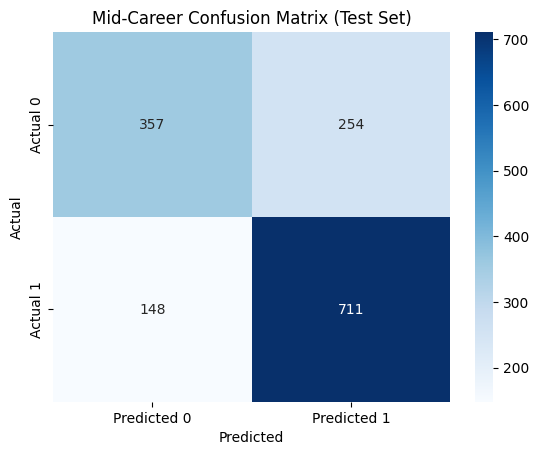

False Positives:
      player_api_id  final_achievement_ratio
5862         300977                 0.918919
3842         165608                 0.941176
6983         536455                 0.858824
4766         203666                 0.937500
4452         187333                 0.923077 

False Negatives:
      player_api_id  final_achievement_ratio
4079         176718                 0.955224
91            15662                 0.956522
4234         181073                 0.969231
3542         150969                 0.968254
180           21726                 0.959459 

True Positives:
      player_api_id  final_achievement_ratio
547           26449                 0.955882
25             8985                 1.000000
3369         145586                 0.971831
1174          37194                 0.986842
1883          43319                 1.000000 

True Negatives:
      player_api_id  final_achievement_ratio
6915         520230                 0.870130
6373         410361         

In [3]:
Developmental Phase Only (22–26)
python
Copy
Edit


In [24]:
print("Current Features in X:")
print(X.columns.tolist())


Current Features in X:
['overall_rating_mean', 'overall_rating_max', 'overall_rating_last', 'stamina_mean', 'stamina_max', 'stamina_last', 'strength_mean', 'strength_max', 'strength_last', 'vision_mean', 'vision_max', 'vision_last', 'acceleration_mean', 'acceleration_max', 'acceleration_last', 'sprint_speed_mean', 'sprint_speed_max', 'sprint_speed_last', 'dribbling_mean', 'dribbling_max', 'dribbling_last', 'finishing_mean', 'finishing_max', 'finishing_last']


##Developmental Phase Only (22–26)




[Developmental Phase Prediction Only (22–26)] (n=5468)
Accuracy: 0.7633 ± 0.0106
F1 Score: 0.8596 ± 0.0069
ROC AUC: 0.7374 ± 0.0180
[Developmental Phase Regression] MSE: 0.0016, MAE: 0.0225, R²: 0.1066
True Positives: 794
False Positives: 233
True Negatives: 37
False Negatives: 30


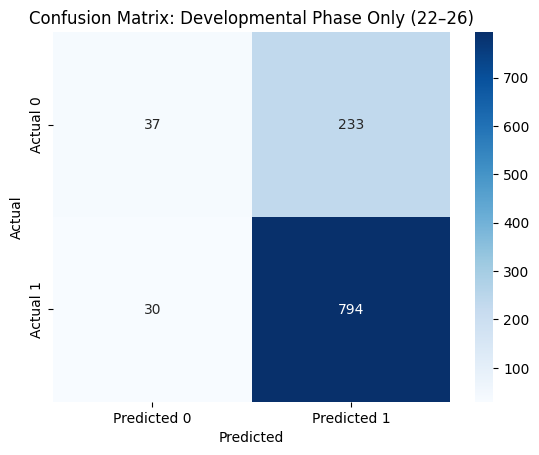

False Positives:
      player_api_id  final_achievement_ratio
5322         427893                 0.946667
1807          45205                 0.931507
4973         281679                 0.921053
4299         199291                 0.925926
2700         109088                 0.937500 

False Negatives:
      player_api_id  final_achievement_ratio
4501         211849                 0.969697
2316          79248                 1.000000
5088         299380                 0.951613
2362          92095                 0.970149
3597         166717                 0.969697 

True Positives:
      player_api_id  final_achievement_ratio
3514         163994                 1.000000
3938         182223                 0.973684
644           27694                 1.000000
3197         149855                 0.971831
2183          71603                 0.985075 

True Negatives:
      player_api_id  final_achievement_ratio
4979         281864                 0.920000
5299         416175         

In [5]:

# Load Data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
player_attr_df = pd.read_sql_query("SELECT player_api_id, date, overall_rating, stamina, strength, vision, acceleration, sprint_speed, dribbling, finishing FROM Player_Attributes", conn)
player_df = pd.read_sql_query("SELECT player_api_id, birthday FROM Player", conn)
conn.close()

# Process Dates
player_attr_df['date'] = pd.to_datetime(player_attr_df['date'])
player_df['birthday'] = pd.to_datetime(player_df['birthday'])

# Merge and Compute Age
player_attr_df = player_attr_df.merge(player_df, on='player_api_id', how='left')
player_attr_df['age'] = (player_attr_df['date'] - player_attr_df['birthday']).dt.days // 365




# Filter strictly between 22 and 26 inclusive
dev_phase_df = player_attr_df[(player_attr_df['age'] >= 22) & (player_attr_df['age'] <= 26)]

# Require at least 5 observations per player in this range
record_counts = dev_phase_df['player_api_id'].value_counts()
qualified_players = record_counts[record_counts >= 5].index
dev_phase_df = dev_phase_df[dev_phase_df['player_api_id'].isin(qualified_players)]

# -----------------------------
# Step 3: Aggregate Features (Mean and Max Only)
# -----------------------------
agg_functions = {
    'overall_rating': ['mean', 'max'],
    'stamina': ['mean', 'max'],
    'strength': ['mean', 'max'],
    'vision': ['mean', 'max'],
    'acceleration': ['mean', 'max'],
    'sprint_speed': ['mean', 'max'],
    'dribbling': ['mean', 'max'],
    'finishing': ['mean', 'max']
}

dev_features_df = dev_phase_df.groupby('player_api_id').agg(agg_functions)
dev_features_df.columns = ['_'.join(col).strip() for col in dev_features_df.columns.values]
dev_features_df = dev_features_df.reset_index()

# -----------------------------
# Step 4: Load Final Career Outcomes
# -----------------------------
features_df = pd.read_csv('/content/drive/MyDrive/Yoni/soccer/player_full_features.csv')
final_outcomes = features_df[['player_api_id', 'final_achievement_ratio']]

dev_features_df = dev_features_df.merge(final_outcomes, on='player_api_id', how='left')

# Define Target (Binary Classification)
target_clf = (dev_features_df['final_achievement_ratio'] > 0.95).astype(int)

# -----------------------------
# Step 5: Prepare Feature Matrix
# -----------------------------
drop_cols = ['player_api_id', 'final_achievement_ratio']
X = dev_features_df.drop(columns=drop_cols, errors='ignore')
X = X.select_dtypes(include=['number']).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Step 6: GroupKFold Cross-Validation
# -----------------------------
cv = GroupKFold(n_splits=5)
groups = dev_features_df['player_api_id'].values
clf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

print(f"\n[Developmental Phase Prediction Only (22–26)] (n={X.shape[0]})")
cv_auc = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring='roc_auc')
cv_f1 = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring='f1')
cv_acc = cross_val_score(clf_model, X_scaled, target_clf, cv=cv, groups=groups, scoring='accuracy')

print(f"Accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"ROC AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# -----------------------------
# Optional Regression Analysis
# -----------------------------
target_reg = dev_features_df['final_achievement_ratio']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target_reg, test_size=0.2, random_state=42)

reg_model = Ridge(alpha=1.0)
reg_model.fit(X_train, y_train)
predictions = reg_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"[Developmental Phase Regression] MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# -----------------------------
# Step 7: Confusion Matrix (on held-out test set)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target_clf, test_size=0.2, random_state=42, stratify=target_clf
)

clf_model.fit(X_train, y_train)
y_proba = clf_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=['Predicted 0', 'Predicted 1'],
             yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Developmental Phase Only (22–26)')
plt.show()

# -----------------------------
# Step 8: Sample Players by Error Type
# -----------------------------
test_df = dev_features_df.iloc[y_test.index].copy()
test_df['prediction'] = y_pred
test_df['actual'] = y_test.values

def sample_examples(df, actual, predicted, n=5):
    subset = df[(df['actual'] == actual) & (df['prediction'] == predicted)]
    if subset.empty:
        print(f"No examples found for Actual={actual}, Predicted={predicted}\n")
        return pd.DataFrame()
    return subset.sample(n=min(n, len(subset)), random_state=42)

def safe_print(label, df):
    print(f"{label}:")
    if df.empty:
        print("  No examples found.\n")
    else:
        print(df[['player_api_id', 'final_achievement_ratio']], "\n")

fp_examples = sample_examples(test_df, actual=0, predicted=1)
fn_examples = sample_examples(test_df, actual=1, predicted=0)
tp_examples = sample_examples(test_df, actual=1, predicted=1)
tn_examples = sample_examples(test_df, actual=0, predicted=0)

safe_print("False Positives", fp_examples)
safe_print("False Negatives", fn_examples)
safe_print("True Positives", tp_examples)
safe_print("True Negatives", tn_examples)
